In [1]:
# Import the dependencies
import os
import sys
import time
from collections import Counter
from dotenv import load_dotenv
from functools import reduce
from itertools import combinations
from joblib import Parallel, delayed
from pymongo import MongoClient
import pymongoarrow as pma
from pymongoarrow.api import write
import numba
from numba.typed import List
import numpy as np
from numpy.random import default_rng
import pandas as pd

from sklearn_extra.cluster import KMedoids
from sklearn.cluster import HDBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import MaxAbsScaler

import hvplot.pandas
from matplotlib import pyplot as plt
from ydata_profiling import ProfileReport

# Suppress YData profile report generation warnings - no actual problems to resolve.
from warnings import simplefilter 
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [2]:
# Apply latest settings for Pandas
pd.options.mode.copy_on_write = True

### Load data from MongoDB

In [3]:
# load the config from the .env file
load_dotenv()
MONGODB_URI = os.environ['MONGODB_URI']

# Connect to the database engine
client = MongoClient(MONGODB_URI)

# connect to the project db
db = client['ExpectLifeRedux']

# get references to the data collections
data1 = db['ELR_Input_Data']
data2 = db['Encoded_Gov_Data']
data3 = db['Encoded_SSS_Data']

### Create DataFrames, Adjust columns, and set Index

In [4]:
# Create a dataframe from the ELR_Data collection
combined_df = pd.DataFrame(list(data1.find()))

# Create a dataframe from the Gov_Clusters collection
gc_df = pd.DataFrame(list(data2.find()))

# Create a dataframe from the SSS_Cluster collection
sc_df = pd.DataFrame(list(data3.find()))

In [5]:
# Create a copy of the original combined dataframe
ori_df = combined_df.copy()

# Drop the database id data and refresh the index
combined_df = combined_df.drop(['_id', 'Country', 'Year'], axis=1)
combined_df = combined_df.reset_index(drop=True)
combined_df = combined_df.set_index('Country_Year')
combined_df = combined_df.drop(['Gov Type', 'SSS Type'], axis=1)
# Sort by index
combined_df = combined_df.sort_index()

gc_df = gc_df.drop(['_id'], axis=1)
gc_df = gc_df.reset_index(drop=True)
gc_df = gc_df.set_index('Country_Year')
# Sort by index
gc_df = gc_df.sort_index()

sc_df = sc_df.drop(['_id'], axis=1)
sc_df = sc_df.reset_index(drop=True)
# Sort by index
sc_df = sc_df.sort_index()

### Scale the numeric data before combining with binary encoded data

In [6]:
# Collect the column labels so they can be reapplied after data scaling
numeric_col_names = combined_df.columns.tolist()

# Standardize the data with MaxAbsScaler().
scaler = MaxAbsScaler()
scaled_nda = scaler.fit_transform(combined_df)

# Convert the scaled-encoded data back to a DataFrame (nda = Numpy Data Array)
scaled_df = pd.DataFrame(scaled_nda, index=combined_df.index)

# Apply the column labels to ensure the data is properly identified
scaled_df = scaled_df.set_axis(numeric_col_names, axis=1)
scaled_df = scaled_df.sort_index()
scaled_df

,SSS Depth,Avg Rainfall (mm/yr),Pop Density (#/sq km),Total Population (M),Total Labor Force (M),LEx years,Doctors (#/10k pop),Electricity Access (% Pop),Current HE (% GDP),Current HE per capita (PPP Intl $),Capital HE (% GDP),Domestic General Gov HE (% GDP),Domestic General Gov HE per capita (PPP Intl $),Domestic Private HE per capita (PPP Intl $),GDP growth per capita %,GDP per capita (PPP Intl $),Daily Caloric Supply,Tobacco use (% adults),Alcohol Use per capita (liters)
Country_Year,,,,,,,,,,,,,,,,,,,
Albania_1990,0.4,0.458333,0.006559,0.002319,0.001758,0.855510,0.162691,1.000000,0.291190,0.019038,0.001596,0.204715,0.015604,0.020498,-0.079641,0.015622,0.661004,0.510949,0.320488
Albania_1991,0.4,0.458333,0.006519,0.002305,0.001829,0.858247,0.172303,1.000000,0.291190,0.019038,0.001596,0.204715,0.015604,0.020498,-0.196233,0.011698,0.662033,0.510949,0.320488
Albania_1992,0.4,0.458333,0.006480,0.002291,0.001840,0.862188,0.189035,1.000000,0.291190,0.019038,0.001596,0.204715,0.015604,0.020498,-0.047142,0.011172,0.683140,0.510949,0.320488
Albania_1993,0.4,0.458333,0.006440,0.002277,0.001808,0.864808,0.162335,1.000000,0.291190,0.019038,0.001596,0.204715,0.015604,0.020498,0.072821,0.012607,0.719434,0.510949,0.320488
Albania_1994,0.4,0.458333,0.006401,0.002263,0.001780,0.867054,0.152486,1.000000,0.291190,0.019038,0.001596,0.204715,0.015604,0.020498,0.063851,0.014031,0.740541,0.510949,0.320488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zimbabwe_2018,0.2,0.202778,0.002128,0.010621,0.007380,0.718313,0.023852,0.454003,0.228792,0.015389,0.053123,0.118002,0.009254,0.011541,0.020710,0.015055,0.491120,0.176642,0.227805
Zimbabwe_2019,0.2,0.202778,0.002170,0.010835,0.007563,0.716886,0.023140,0.466821,0.179282,0.011286,0.469491,0.038642,0.002836,0.005581,-0.058210,0.014072,0.491120,0.176642,0.227805
Zimbabwe_2020,0.2,0.202778,0.002215,0.011057,0.007685,0.714921,0.022428,0.527477,0.167810,0.010094,0.036520,0.056014,0.003928,0.004664,-0.068838,0.012877,0.491120,0.170803,0.227805


### Assemble the complete dataset by merging the frames

In [7]:
# Merge the cluster DataFrames with the primary data.
frames = [scaled_df, gc_df, sc_df]
merge_frames_df = reduce(lambda left,right: pd.merge(left,right,how='left',on='Country_Year'),frames)

complete_df = merge_frames_df.copy().reset_index(drop=True)
complete_df = complete_df.set_index('Country_Year')
complete_df = complete_df.sort_index()
complete_df

,SSS Depth,Avg Rainfall (mm/yr),Pop Density (#/sq km),Total Population (M),Total Labor Force (M),LEx years,Doctors (#/10k pop),Electricity Access (% Pop),Current HE (% GDP),Current HE per capita (PPP Intl $),...,Universal (birth grant),Universal (cash maternity benefits),Universal (cash parental grants),Universal (paid parental leave),Universal (parental benefits),Universal (pregnancy grant),Universal (prenatal care grant),Universal medical benefits,Voluntary community-based social insurance system (medical benefits),Voluntary pension scheme
Country_Year,,,,,,,,,,,,,,,,,,,,,
Albania_1990,0.4,0.458333,0.006559,0.002319,0.001758,0.855510,0.162691,1.000000,0.291190,0.019038,...,0,0,0,0,0,0,0,1,0,0
Albania_1991,0.4,0.458333,0.006519,0.002305,0.001829,0.858247,0.172303,1.000000,0.291190,0.019038,...,0,0,0,0,0,0,0,1,0,0
Albania_1992,0.4,0.458333,0.006480,0.002291,0.001840,0.862188,0.189035,1.000000,0.291190,0.019038,...,0,0,0,0,0,0,0,1,0,0
Albania_1993,0.4,0.458333,0.006440,0.002277,0.001808,0.864808,0.162335,1.000000,0.291190,0.019038,...,0,0,0,0,0,0,0,1,0,0
Albania_1994,0.4,0.458333,0.006401,0.002263,0.001780,0.867054,0.152486,1.000000,0.291190,0.019038,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zimbabwe_2018,0.2,0.202778,0.002128,0.010621,0.007380,0.718313,0.023852,0.454003,0.228792,0.015389,...,0,0,0,0,0,0,0,0,0,0
Zimbabwe_2019,0.2,0.202778,0.002170,0.010835,0.007563,0.716886,0.023140,0.466821,0.179282,0.011286,...,0,0,0,0,0,0,0,0,0,0
Zimbabwe_2020,0.2,0.202778,0.002215,0.011057,0.007685,0.714921,0.022428,0.527477,0.167810,0.010094,...,0,0,0,0,0,0,0,0,0,0


### Assemble the complete visualization dataset by merging the unscaled numeric and binary encoded frames

In [8]:
# Prepare the visualization dataframe
frames = [combined_df, gc_df, sc_df]
merge_df = reduce(lambda left,right: pd.merge(left,right,how='left',on='Country_Year'),frames)

In [9]:
viz_df = merge_df.copy().reset_index(drop=True)
viz_df = viz_df.set_index('Country_Year')
viz_df = viz_df.sort_index()
viz_df

,SSS Depth,Avg Rainfall (mm/yr),Pop Density (#/sq km),Total Population (M),Total Labor Force (M),LEx years,Doctors (#/10k pop),Electricity Access (% Pop),Current HE (% GDP),Current HE per capita (PPP Intl $),...,Universal (birth grant),Universal (cash maternity benefits),Universal (cash parental grants),Universal (paid parental leave),Universal (parental benefits),Universal (pregnancy grant),Universal (prenatal care grant),Universal medical benefits,Voluntary community-based social insurance system (medical benefits),Voluntary pension scheme
Country_Year,,,,,,,,,,,,,,,,,,,,,
Albania_1990,2,1485.0,119.946788,3.286542,1.374478,73.144,13.71,100.000000,5.944186,222.786533,...,0,0,0,0,0,0,0,1,0,0
Albania_1991,2,1485.0,119.225912,3.266790,1.429833,73.378,14.52,100.000000,5.944186,222.786533,...,0,0,0,0,0,0,0,1,0,0
Albania_1992,2,1485.0,118.505073,3.247039,1.438342,73.715,15.93,100.000000,5.944186,222.786533,...,0,0,0,0,0,0,0,1,0,0
Albania_1993,2,1485.0,117.784197,3.227287,1.413557,73.939,13.68,100.000000,5.944186,222.786533,...,0,0,0,0,0,0,0,1,0,0
Albania_1994,2,1485.0,117.063358,3.207536,1.391914,74.131,12.85,100.000000,5.944186,222.786533,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zimbabwe_2018,1,657.0,38.909614,15.052184,5.770226,61.414,2.01,45.400288,4.670418,180.091128,...,0,0,0,0,0,0,0,0,0,0
Zimbabwe_2019,1,657.0,39.691374,15.354608,5.912685,61.292,1.95,46.682095,3.659765,132.068691,...,0,0,0,0,0,0,0,0,0,0
Zimbabwe_2020,1,657.0,40.505793,15.669666,6.008633,61.124,1.89,52.747667,3.425581,118.127063,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Define a function that generates a profile report and saves it to a file
def generate_report(df, config_file, output_file):
    profile = ProfileReport(df, config_file=config_file)
    profile.to_file(output_file)
    print(f"Report {output_file} generated.")

### Determine number of components for PCA ###

In [11]:
# Function to compute the viable PCA components for a given dataset
def compute_pca(input_data):  
    # Fit PCA on actual data
    pca_actual = PCA(svd_solver='full').fit(input_data)
    
    cumulative_variance_ratio = np.cumsum(pca_actual.explained_variance_ratio_)
    plt.plot(cumulative_variance_ratio)
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')
    plt.axhline(y=0.95, color='r', linestyle='-')
    plt.show()

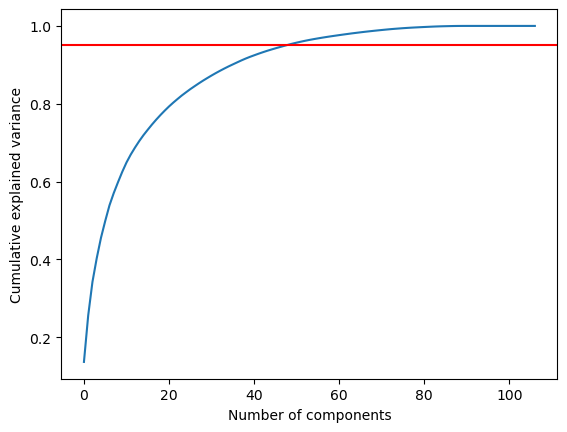

In [12]:
# Determine the number of appropriate components for PCA (scaled (combined) data)
compute_pca(complete_df)

In [13]:
# Function to perform PCA for the provided data
def perform_pca(input_data, name, n_comp):
    pca = PCA(n_components=n_comp, random_state=42)
    pca_out = pca.fit_transform(input_data)

    # Create a DataFrame with the principal components.
    columnz =[]

    for i in range(1,n_comp+1):
        columnz.append(name + '_pc'+str(i))
    
    out_df = pd.DataFrame(data=pca_out, columns=columnz)

    out_df['Country_Year'] = ori_df['Country_Year']
    out_df = out_df.reset_index(drop=True)
    out_df = out_df.set_index('Country_Year')
    return out_df

#### Use the PCA data to guide component number selection

In [14]:
# Perform PCA on the complete_df.
complete_pca_df = perform_pca(complete_df, 'Complete', 45)

### Determine the number of (KMedoids) clusters for this complete dataset

In [15]:
# Use KMedoids and compute Davies-Bouldin scores, elbow curve, and silhouette scores to determine the optimal number of clusters.
def compute_kmedoids_cluster_metrics(data_in, n_clusters):
    """
    Function to compute cluster metrics for a given number of clusters.
    This function will be called in parallel.
    """
    # Initialize the clusterer with n_clusters value and random state for reproducibility
    clusterer = KMedoids(n_clusters=n_clusters, init='k-medoids++', random_state=42)
    cluster_labels = clusterer.fit_predict(data_in)
    
    # Compute the scores for various metrics
    davies_bouldin = davies_bouldin_score(data_in, cluster_labels)
    inertia = clusterer.inertia_
    silhouette_avg = silhouette_score(data_in, cluster_labels)
    
    return n_clusters, davies_bouldin, inertia, silhouette_avg
    
def compute_clusters_parallel(data_in, max_clusters, n_jobs):
    # Parallel computation of the cluster metrics for each number of clusters from 2 to max_clusters
    # Make a writable copy of the input data
    data_copy = np.array(data_in)
    
    parallel = Parallel(n_jobs=n_jobs)
    kmedoids_cluster_metrics_list = parallel(delayed(compute_kmedoids_cluster_metrics)(data_copy, n_clusters)
                                    for n_clusters in range(2, max_clusters + 1))

    # Creating a DataFrame to store the clustering metrics
    kmedoids_cluster_metrics_df = pd.DataFrame(kmedoids_cluster_metrics_list,
                                      columns=['Num_Clusters', 'Davies_Bouldin', 'Inertia', 'Silhouette_Avg'])

    return kmedoids_cluster_metrics_df

### Compute KMedoids clusters and metrics for the complete dataset

In [16]:
# Start timing
start = time.perf_counter()

# Create a DataFrame of the results for further analysis downstream - Compute clusters for the complete dataframe
non_pca_kmedoid_cluster_scores_df = compute_clusters_parallel(data_in=complete_df, max_clusters=60, n_jobs=-1)

# Stop timing
stop = time.perf_counter()

print(f"KMedoids Clustering Execution in {stop - start:0.4f} seconds")

KMedoids Clustering Execution in 18.5067 seconds


### Compute KMedoids clusters and metrics for the PCA dataset

In [17]:
# Start timing
pca_kmedoid_cluster_start = time.perf_counter()

# Create a DataFrame of the results for further analysis downstream - Compute clusters for the complete dataframe with PCA
pca_kmedoid_cluster_scores_df= compute_clusters_parallel(data_in=complete_pca_df, max_clusters=60, n_jobs=-1)

# Stop timing
pca_kmedoid_cluster_stop = time.perf_counter()

print(f"PCA KMedoids Clustering Execution in {pca_kmedoid_cluster_stop - pca_kmedoid_cluster_start:0.4f} seconds")

PCA KMedoids Clustering Execution in 15.2560 seconds


In [18]:
# Lower scores are better
pca_kmedoid_cluster_scores_df.hvplot.scatter(x='Num_Clusters', y='Davies_Bouldin')

:Scatter   [Num_Clusters]   (Davies_Bouldin)

In [19]:
# Higher scores are better
pca_kmedoid_cluster_scores_df.hvplot.scatter(x='Num_Clusters', y='Silhouette_Avg')

:Scatter   [Num_Clusters]   (Silhouette_Avg)

In [20]:
# define the model
cluster_model = KMedoids(n_clusters=55, init='k-medoids++', random_state=42)

# Fit the model and predict labels
cluster_model.fit_predict(complete_pca_df)

# Add the predicted class columns to the visualization dataset
complete_pca_viz_df = viz_df.copy()
complete_pca_viz_df['KMedoids Clusters'] = cluster_model.labels_

## Principal Feature Analysis ##

#### Define functions to select dataset features that provide relevant information for clustering. 
##### Only important features are used to compute clusters from the complete (non-pca) dataset.

In [21]:
# =============================================================================
# Helper function - Custom Mean processing to override limitations of Numba compatibility with Numpy features
@numba.jit(nopython=True)
def custom_mean(arr):
    if arr.ndim == 1:
        return arr.mean()
    elif arr.ndim == 2:
        # For 2D arrays, manually compute the mean of each column.
        means = np.zeros(arr.shape[1])
        for i in range(arr.shape[1]):
            means[i] = arr[:, i].mean()
        return means
    else:
        raise ValueError("Invalid array dimensions for custom_mean")

In [22]:
# =============================================================================
# Helper function - Calinski Harbasz Score Calculation
def calculate_calinski_harbasz(np_array, labels):
    if len(np.unique(labels)) > 1:
        c_h = calinski_harabasz_score(np_array, labels)
        calinski_harbasz = log_scale_value(c_h)
        #print(f'    calinski_harbasz index = {calinski_harbasz}')
        return calinski_harbasz
    else:
        return 0

In [23]:
# =============================================================================
# Helper function - Davies-Bouldin Score Calculation
def calculate_davies_bouldin(np_array, labels):
    if len(np.unique(labels)) > 1:
        davies_bouldin = davies_bouldin_score(np_array, labels)
        #print(f'   davies_bouldin score = {davies_bouldin}')
        return davies_bouldin
    else:
        return 0

In [24]:
# =============================================================================
# Helper function - Silhouette Coefficient Calculation
def calculate_silhouette(np_array, labels):
    if len(np.unique(labels)) > 1:
        silhouette_val = silhouette_score(np_array, labels)
        #print(f' Silhouette Score = {silhouette_val}')
        return silhouette_val
    else:
        return 0

In [25]:
# =============================================================================
# Helper function - Scatter Separability Calculation
def calculate_scatter_separability(np_array, labels):
    """
    Calculates the Scatter Separability (SSC) between clusters in a NumPy array.

    Args:
        np_array: The NumPy array containing the data points.
        labels: The cluster labels for each data point.

    Returns:
        The Scatter Separability score (SSC).
    """
    unique_labels = np.unique(labels)
    n_features = np_array.shape[1]
    overall_mean = custom_mean(np_array)

    S_w = np.zeros((n_features, n_features))
    S_b = np.zeros((n_features, n_features))

    for label in unique_labels:
        X_k = np_array[labels == label]
        mean_k = custom_mean(X_k)
        if mean_k.ndim == 1:
            mean_k = mean_k[:, None]  # Ensure mean_k is a column vector
        n_k = X_k.shape[0]  # Number of samples in current class
        mean_diff = mean_k - overall_mean[:, None]  # Ensure mean_diff is correctly shaped
    
        S_w_k = np.cov(X_k, rowvar=False, bias=True) * (n_k - 1)  # Compute within-class scatter for class k
        S_w += S_w_k
    
        mean_diff = mean_diff.reshape(-1, 1)  # Reshape mean_diff as column vector if not already
        S_b += n_k * np.dot(mean_diff, mean_diff.T)  # Correct outer product computation

    # Handle singular S_w by adding a small identity matrix to ensure invertibility
    if np.linalg.cond(S_w) > 1e10:
        S_w += np.eye(S_w.shape[0]) * 1e-4

    ssc = np.trace(np.linalg.inv(S_w).dot(S_b))
    final_ssc = log_scale_value(ssc)
    #print(f'+ computed SSC - value = {final_ssc} ')
    return final_ssc

In [26]:
# =============================================================================
# Helper function - Performs Logarithmic scaling of cluster quality score metrics that have unbounded positive ranges - Numba acceleration
@numba.jit(nopython=True)
def log_scale_value(value, offset=1):
    """
    Applies a logarithmic scaling to a value.
    
    Parameters:
    - value: The positive metric value to be scaled.
    - offset: A small positive value to avoid log(0) when the metric is zero.
    - scale_max: An upper limit to scale the logarithmic value to, for normalization.
    
    Returns:
    - scaled_value: The logarithmically scaled value, normalized to the range [0, scale_max].
    """
    # Apply logarithmic scaling
    log_scaled_value = np.log(value + offset)
    
    # TBD, normalize the log-scaled value to a specific range, e.g., [0, scale_max]
    # if/when implemented, add ", scale_max=1000" as a function parameter
    
    return log_scaled_value


In [27]:
# =============================================================================
# Helper function - Normalization of criterion values to remove bias due to number of clusters - Numba acceleration
@numba.jit(nopython=True)
def cross_projection_normalization(clustering_medoids, scatter_criteria_score, silhouette_criteria_score, davies_bouldin_score, calinski_harbasz_index):
    n_clusters = len(clustering_medoids)
    projections = np.zeros((n_clusters, n_clusters))

    for j in range(n_clusters):
        for k in range(j + 1, n_clusters):
            medoid_j = clustering_medoids[j]
            medoid_k = clustering_medoids[k]
            distance = np.linalg.norm(medoid_j - medoid_k)
            projections[j][k] = distance
            projections[k][j] = distance

   # Check if all distances are zero
    if np.all(projections == 0):
        #print("CNP - All pairwise distances are zero! Cannot compute Normalized Score.")
        return 0 
    
    # Flatten the array and filter non-zero distances
    flat_projections = projections.ravel()
    non_zero_projections = flat_projections[flat_projections > 0]
    
    if non_zero_projections.size == 0:
        #print("CNP - non_zero_projections is empty. Cannot compute Normalized Score.")
        return 0

    # Calculate mean of non-zero distances
    mean_projection = np.mean(non_zero_projections)

    # Normalizing the criteria scores with the mean of projections
    # Adjusting the formula to consider Davies-Bouldin Score. Recall: For Davies-Bouldin, lower is better.
    # We add 1 to both the numerator and denominator to ensure it doesn't lead to division by zero or negative values.

    # Combined normalization factor incorporates all metrics.
    normalization_denominator = (1 + mean_projection + davies_bouldin_score) 
    normalization_numerator = (1 + scatter_criteria_score + silhouette_criteria_score + calinski_harbasz_index)
    normalized_score = normalization_numerator / normalization_denominator

    return normalized_score

In [28]:
# =============================================================================
# Primary function - calls functions to generate cluster metrics in parallel
def score_subset_clusters(subset_array, np_array, cluster_labels, clustering_medoids):
    # Define tasks to be executed in parallel
    tasks = [delayed(calculate_scatter_separability)(subset_array, cluster_labels),
             delayed(calculate_silhouette)(subset_array, cluster_labels),
             delayed(calculate_davies_bouldin)(subset_array, cluster_labels),
             delayed(calculate_calinski_harbasz)(subset_array, cluster_labels)]
    
    # Execute tasks in parallel and unpack results
    scatter_separability, silhouette_score, davies_bouldin_score, calinski_harbasz_index = Parallel(n_jobs=4)(tasks)
    
    # Pass the results to the normalization function
    normalized_score = cross_projection_normalization(clustering_medoids, scatter_separability, silhouette_score, davies_bouldin_score, calinski_harbasz_index)

    return normalized_score

In [29]:
# =============================================================================
# Primary function - Initializes the clustering algorithm
def initialize_clustering_instance(clustering_algorithm, rng, flag):
    if flag == 'reverse': # Use vanilla algoritms for reverse-search feature scoring to ensure a consistent comparison
        if clustering_algorithm == 'kmedoids':
            return KMedoids(n_clusters=2, init='k-medoids++'), 0, 'na', 0, 0
        elif clustering_algorithm == 'hdbscan':
            return HDBSCAN(store_centers="medoid", n_jobs=-1), 0, 'na', 0, 0
    else:
        metrics = ['manhattan', 'euclidean', 'chebyshev', 'canberra', 'hamming']  # Available metrics - pick one
        if clustering_algorithm == 'kmedoids':
            #metrics = ['manhattan', 'euclidean', 'cosine']  # Available metrics - pick one
            k_val = rng.integers(2, 10)
            metric = rng.choice(metrics)  # Randomly select a metric
            return KMedoids(n_clusters=k_val, init='k-medoids++', metric=metric), k_val, metric, 0, 0
        elif clustering_algorithm == 'hdbscan':
            min_cluster_size = rng.choice([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150])
            min_samples = min_cluster_size + rng.choice([10, 20, 30, 40, 50, 60, 70]) # Higher values force conservative clustering
            metric = rng.choice(metrics)  # Randomly select a metric
            return HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, metric=metric, cluster_selection_method='eom', store_centers="medoid", n_jobs=-1), 0, metric, min_cluster_size, min_samples
        else:
            raise ValueError("Unsupported clustering algorithm")

In [30]:
# =============================================================================
# Primary function - Evaluates the subset_array
def evaluate_subset(clustering_algorithm, subset_array, np_array, rng, flag):
    clustering_instance, k_val, metric, min_cluster_size, min_samples = initialize_clustering_instance(clustering_algorithm, rng, flag)
    current_labels = clustering_instance.fit_predict(subset_array)
    clustering_medoids = getattr(clustering_instance, 'cluster_centers_', getattr(clustering_instance, 'medoids_', None))
    return score_subset_clusters(subset_array, np_array, current_labels, clustering_medoids), k_val, metric, min_cluster_size, min_samples

In [31]:
# =============================================================================
# Primary function - Creates a starter_set from the available_indices
def select_starter_set(available_indices, interim_features, starter_set_size, rng):
    remaining_indices = list(available_indices - interim_features)
    if len(remaining_indices) <= starter_set_size: # Check if there are enough indices to create a full starter_set
        return rng.shuffle(remaining_indices), 0
    else:
        return rng.choice(remaining_indices, starter_set_size, replace=False), 1

In [32]:
# =============================================================================
# Primary function - Adds a new score and the clustering parameters to the collection
def update_best_scores(best_scores, score, feature, k_val, metric, cluster_size, num_samples, interim_features, available_indices):
    best_scores['k_val'].append(k_val) # K-Medoids - Track the target k
    best_scores['cluster_size'].append(cluster_size) # HDBSCAN - Track the size of the clusters
    best_scores['num_samples'].append(num_samples)  # HDBSCAN - Track the number of samples per cluster
    best_scores['metric'].append(metric)  # K-Medoids - Track the metric
    interim_features.add(feature)
    available_indices.remove(feature)
    return available_indices, interim_features, best_scores

In [33]:
# =============================================================================
# Primary function - Score the interim_features as they are removed - determine whether any ore not needed.
def evaluate_feature_removal(np_array, clustering_algorithm, current_features, feature_to_remove, rng, flag):
    # Remove the specified feature from the current feature set
    modified_features = [f for f in current_features if f != feature_to_remove]
    
    # Subset the np_array to include only the modified feature set
    subset_array = np_array[:, modified_features]
    
    # Evaluate the clustering with the modified feature set
    score, _, _, _, _, = evaluate_subset(clustering_algorithm, subset_array, np_array, rng, flag)
    
    return score

In [34]:
# =============================================================================
# Primary function - Evaluate the scored interim_features - remove unneeded if below criteria.
def perform_reverse_search(np_array, clustering_algorithm, interim_features, global_removal_score, rng):
    refined_features = set(interim_features)
    local_removal_score = global_removal_score  # Initialize local removal score with global_removal_score
    feature_removed = True

    print(' --------------- Beginning Reverse-searching to refine the interim_features ... --------------- ')

    while feature_removed:
        if len(refined_features) == 5:
            print('Need to collect more candidate features - we have 5 features left.')
            return refined_features, local_removal_score
        else:
            test_scores = []  # Store feature removal scores for comparison
    
            # Evaluate feature removal in parallel
            test_scores = Parallel(n_jobs=12)(
                delayed(evaluate_feature_removal)(np_array, clustering_algorithm, list(refined_features), feature, rng, 'reverse')
                for feature in refined_features
            )
            test_scores = list(zip(refined_features, test_scores))  # Combine feature indices with their scores
    
            candidate_removal, candidate_score = max(test_scores, key=lambda x: x[1])  # Use the key argument of the max() function to specify that we want to find the maximum based on the second element of each tuple in test_scores
    
            if candidate_score > (local_removal_score + 0.25):  # The score improves with the feature removed and is better than the local best score
                refined_features.remove(candidate_removal)
                local_removal_score = candidate_score  # Update the local best score
                print(f' Feature {candidate_removal} was removed from the refined_features. Current removal score is {local_removal_score:.4f}')
                feature_removed = True
            else:
                print(' No feature met the removal criteria ')
                feature_removed = False
    
    return refined_features, local_removal_score

In [35]:
# =============================================================================
# Primary function - Evaluate the available indices - iterate through the collection to identify those that improve scores by removal.
def perform_reverse_index_removal(np_array, clustering_algorithm, available_indices, global_removal_score, rng):
    indices_removed = True  # Flag to track if any features were removed in the last pass
    local_removal_score = global_removal_score

    print(' --------------- Starting Reverse Index Removal --------------- ')
    while indices_removed: # remove as many as possible for each run...
        indices_removed = False  # Reset the flag for the current pass
        if len(available_indices) == 10:
            print('No index removal possible.')
            return available_indices, local_removal_score
        else:
            test_scores = []  # Store feature removal scores for comparison

            # Evaluate feature removal in parallel
            test_scores = Parallel(n_jobs=12)(
                delayed(evaluate_feature_removal)(np_array, clustering_algorithm, list(available_indices), feature, rng, 'reverse')
                for feature in available_indices
            )
            test_scores = list(zip(available_indices, test_scores))  # Combine feature indices with their scores

            candidate_removal, candidate_score = max(test_scores, key=lambda x: x[1])  # Use the key argument of the max() function to specify that we want to find the maximum based on the second element of each tuple in test_scores

            if candidate_score > (local_removal_score + 0.20):  # The score improves with the feature removed and is incrementally better than the global removal score
                available_indices.remove(candidate_removal)
                indices_removed = True  # Indicate that an index was removed in this pass
                local_removal_score = candidate_score  # Update the global removal score
                print(f' Index {candidate_removal} was removed. The current removal score is {local_removal_score:.4f}')

    print(f' ---- Reverse Index Removal completed ---- {len(available_indices)} available_indices remaining. ')
    return available_indices, local_removal_score

In [36]:
# =============================================================================
# Helper function - Shuffles the contents of the feature array during combination evaluation
def shuffle_array(array, rng):
    # Shuffle the array along the first axis (rows)
    shuffled_array = array.copy()
    rng.shuffle(shuffled_array, axis=0)
    return shuffled_array

In [37]:
# =============================================================================
# Primary function - Evaluates new features alongside the initial collection of important features
def evaluate_combinations(np_array, clustering_algorithm, available_indices, refined_features, rng, best_scores, global_best_score, global_removal_score):
    iteration = 0

    print(' *************** Begin combination evaluation ...  *************** ')
    
    for _ in range(200):  # Number of iterations to refine the feature set
        iteration += 1

        # Create a list of features to evaluate
        features_to_evaluate = list(available_indices - refined_features)

        # Evaluate combination and features in parallel
        evaluation_results = Parallel(n_jobs=12)(
            delayed(evaluate_subset)(clustering_algorithm, shuffle_array(np_array[:, list(refined_features) + [feature]], rng), np_array, rng, 'na')
            for feature in features_to_evaluate
        )

        for idx, (normalized_score, k_val, metric, cluster_size, num_samples) in enumerate(evaluation_results):
            feature = features_to_evaluate[idx]

            # Update best combination if necessary
            if normalized_score > global_best_score:
                global_best_score = normalized_score
                best_feature = feature
                best_clust = cluster_size
                best_num_samps = num_samples
                best_k = k_val
                best_metric = metric

                # If a better combination was found, add its feature to refined_features
                available_indices, refined_features, best_scores = update_best_scores(best_scores, global_best_score, best_feature, best_k, best_metric, best_clust, best_num_samps, refined_features, available_indices)
                print(f'+++ Feature Number {best_feature} added to refined_features with score = {global_best_score:.4f} - {len(refined_features)} refined_features found so far...')

        if iteration % 20 == 0:
            print(f'Combination Evaluation Iteration {iteration}')
        
    print(f'Processing completed - Total number of identified features = {len(refined_features)}')

    return available_indices, refined_features, best_scores, global_best_score, global_removal_score

In [38]:
# =============================================================================
# Primary function - Select candidate features from the available_indices via starter_sets
def select_candidate_features_via_starter_set(np_array, clustering_algorithm, n_features, interim_features, available_indices, best_scores, global_best_score, global_removal_score, big_score_jump, rng):
    best_score = 8
    ss_flag = 1  # Initalize the local variable in case this function is entered and the processing is skipped
    feature_percent = int(len(available_indices) * 0.1)
    starter_set_size = feature_percent
    k_val, min_cluster_size, min_samples, cluster_size, num_samples, iteration = 0, 0, 0, 0, 0, 0

    print(' +++++++++++++++ Begin selecting candidate features via starter_sets ... +++++++++++++++ ')
    
    if global_best_score > best_score: # Test for the larger value and carry it forward.
        best_score = global_best_score
       
    while True:  # Simulate a do-while loop
        updated = False # Reset the flag for the next round
        starter_set, ss_flag = select_starter_set(available_indices, interim_features, starter_set_size, rng)

        # Create a list of features to evaluate
        features_to_evaluate = list(available_indices - interim_features - set(starter_set))

        # Evaluate features in parallel
        evaluation_results = Parallel(n_jobs=12)(
            delayed(evaluate_subset)(clustering_algorithm, np_array[:, list(starter_set) + [feature]], np_array, rng, 'na')
            for feature in features_to_evaluate
        )

        for idx, (normalized_score, k_val, metric, cluster_size, num_samples) in enumerate(evaluation_results):
            feature = features_to_evaluate[idx]

            # Update best feature if necessary
            if normalized_score > best_score:
                if (normalized_score - best_score) > 20:
                    big_score_jump = True
                    interim_features.update(starter_set)
                    available_indices.difference_update(starter_set)
                    print(' +*+*+*+*+*+*  Detected a big_score_jump - Added the entire starter_set to the interim_features *+*+*+*+*+*+')
                best_score = normalized_score
                best_new_feature = feature
                best_clust = cluster_size
                best_num_samps = num_samples
                best_k = k_val
                best_metric = metric
                
                available_indices, interim_features, best_scores = update_best_scores(best_scores, best_score, best_new_feature, best_k, best_metric, best_clust, best_num_samps, interim_features, available_indices)
                print(f'Found a new interim feature: {best_new_feature} - with score = {best_score:.4f} - {len(interim_features)} found so far...')
                iteration = 0  # Reset the flag
        
        if len(interim_features) < feature_percent:
            if ss_flag == 0:
                print(' Finished processing all available features ... ')
                break
            else:
                iteration += 1
                if iteration % 40 ==0:
                    print(f' Starter_set Filling Iteration {iteration}')
                if (iteration % 200 ==0) and big_score_jump: # Starter_set feature searching has stalled due to big score jump - exit
                    break
                if (iteration % 500 ==0): # Starter_set feature searching has stalled for some other reason - exit
                    break
        else:
            print(' Completed starter_set processing ... ')
            break

    return available_indices, interim_features, best_scores, best_score, ss_flag, global_removal_score, big_score_jump

In [39]:
# =============================================================================
# Main function - Orchestrates the analysis
def optimal_feature_clusters(np_array, clustering_algorithm):
    rng = default_rng()  # Use numpy's random number generation.
    n_features = np_array.shape[1]
    available_indices = set(range(n_features))
    feature_percent = int(len(available_indices) * 0.1)
    interim_features = set()
    best_scores = {'k_val': [], 'cluster_size': [], 'num_samples': [], 'metric': []}
    starter_removal_score = 1  # Separate score required for the different removal processing
    placeholder_score = 1 # Placeholder score for first pass into select_candidate_features_via_starter_set
    big_score_jump = False  #Prepare the flag for locating a very important feature

    # Start the processing by looking for features that negatively impact scoring - remove them from the set (reducing set size increases processing speed).
    print(' Start processing ... ')
    available_indices, global_removal_score = perform_reverse_index_removal(np_array, clustering_algorithm, available_indices, starter_removal_score, rng)

    available_indices, interim_features, best_scores, best_score, ss_flag, global_removal_score, big_score_jump = select_candidate_features_via_starter_set(np_array, clustering_algorithm, n_features, interim_features, available_indices, best_scores, placeholder_score, global_removal_score, big_score_jump, rng)
    global_best_score = best_score  # Initialize global best score
    updated = True
    
    while updated and (ss_flag == 1):
        # Use the current candidates to locate any new important features
        available_indices, refined_features, best_scores, best_score, global_removal_score = evaluate_combinations(np_array, clustering_algorithm, available_indices, interim_features, rng, best_scores, global_best_score, global_removal_score)
        global_best_score = best_score   # Update global best score to the current top score

        # Test the current candidates to remove any that appear to be restricting the scores
        refined_features, global_removal_score = perform_reverse_search(np_array, clustering_algorithm, refined_features, global_removal_score, rng)
        refined_features_after_reverse_search = len(refined_features)  # Collect the current number of refined features
        
        if big_score_jump:
            # Try to remove any unimportant indices
            available_indices, global_removal_score = perform_reverse_index_removal(np_array, clustering_algorithm, available_indices, global_removal_score, rng)
            # Make a limited attempt to locate any more features with the starter sets
            available_indices, refined_features, best_scores, best_score, ss_flag, global_removal_score, big_score_jump = select_candidate_features_via_starter_set(np_array, clustering_algorithm, n_features, refined_features, available_indices, best_scores, global_best_score, global_removal_score, big_score_jump, rng)
            global_best_score = max(global_best_score, best_score)   # Update global best score to the current top score, if necessary
            if len(refined_features) > refined_features_after_reverse_search:  # Test if we have collected more features through the processing
                updated = True
                print(' Moving to next iteration... ') # Looks like we got past the big score jump
                big_score_jump = False # Reset the flag
                continue
            else:
                print(' Processing completed. ') # Still blocked by the big score jump
                break
        else: # Continue processing features
            updated = False

            # Identify any more of the available_indices that negatively affect scoring - remove them
            available_indices, global_removal_score = perform_reverse_index_removal(np_array, clustering_algorithm, available_indices, global_removal_score, rng)
            
            if len(refined_features) < feature_percent:
                # Try to collect more candidate features ...
                available_indices, refined_features, best_scores, best_score, ss_flag, global_removal_score, big_score_jump = select_candidate_features_via_starter_set(np_array, clustering_algorithm, n_features, refined_features, available_indices, best_scores, global_best_score, global_removal_score, big_score_jump, rng)
                global_best_score = best_score   # Update global best score to the current top score
            else: # We have a full set of features to process
                # Perform combination evaluation
                available_indices, refined_features, best_scores, new_best_score, global_removal_score = evaluate_combinations(np_array, clustering_algorithm, available_indices, refined_features, rng, best_scores, global_best_score, global_removal_score)
                global_best_score = best_score   # Update global best score to the current top score
                
                if len(refined_features) > refined_features_after_reverse_search:  # Test if we have collected more features through the processing
                    updated = True
                    print(' Moving to next iteration... ')
                else:
                    print(' Processing completed. ')

    return best_scores['k_val'], best_scores['metric'], refined_features, best_scores['cluster_size'], best_scores['num_samples'],

### Perform PFA

#### KMedoids

In [40]:
# ^^^^^^^^^^^^^^^^^KMedoids Run 1 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Start timing
start = time.perf_counter()

best_kmedoid_features_run1 = set()

complete1_df = complete_df.copy()
complete1_np = complete1_df.to_numpy()

# Run the experiment using the complete (non-pca) dataframe and identify the clustering algorithm by name.
best_k_vals_run1, best_kmetric_run1, best_kmedoid_features_run1, na1, na2 = optimal_feature_clusters(complete1_np, 'kmedoids')

# Stop timing
stop = time.perf_counter()

print(f' ^^^ RUN #1 --- PFA KMedoids Clustering Execution in {stop - start:0.4f} seconds ^^^ ')
print(f' Best k values = {sorted(best_k_vals_run1)}')
print(f' Best metric values = {sorted(best_kmetric_run1)}')
print(f' best features = {sorted(best_kmedoid_features_run1)}')

 Start processing ... 
 --------------- Starting Reverse Index Removal --------------- 
 Index 8 was removed. The current removal score is 1.9255
 ---- Reverse Index Removal completed ---- 106 available_indices remaining. 
 +++++++++++++++ Begin selecting candidate features via starter_sets ... +++++++++++++++ 
Found a new interim feature: 2 - with score = 8.2341 - 1 found so far...
Found a new interim feature: 3 - with score = 8.3461 - 2 found so far...
Found a new interim feature: 13 - with score = 8.3615 - 3 found so far...
Found a new interim feature: 14 - with score = 8.4082 - 4 found so far...
Found a new interim feature: 73 - with score = 8.4108 - 5 found so far...
Found a new interim feature: 89 - with score = 8.4128 - 6 found so far...
Found a new interim feature: 19 - with score = 9.1928 - 7 found so far...
Found a new interim feature: 39 - with score = 9.2663 - 8 found so far...
Found a new interim feature: 88 - with score = 9.4585 - 9 found so far...
Found a new interim fea

In [41]:
# ^^^^^^^^^^^^^^^^^KMedoids Run 2 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Start timing
start = time.perf_counter()

best_kmedoid_features_run2 = set()

complete2_df = complete_df.copy()
complete2_np = complete2_df.to_numpy()

# Run the experiment using the complete (non-pca) dataframe and identify the clustering algorithm by name.
best_k_vals_run2, best_kmetric_run2, best_kmedoid_features_run2, na1, na2 = optimal_feature_clusters(complete2_np, 'kmedoids')

# Stop timing
stop = time.perf_counter()

print(f' ^^^ RUN #2 --- PFA KMedoids Clustering Execution in {stop - start:0.4f} seconds ^^^ ')
print(f' Best k values = {sorted(best_k_vals_run2)}')
print(f' Best metric values = {sorted(best_kmetric_run2)}')
print(f' best features = {sorted(best_kmedoid_features_run2)}')

 Start processing ... 
 --------------- Starting Reverse Index Removal --------------- 
 Index 33 was removed. The current removal score is 2.5115
 Index 84 was removed. The current removal score is 4.9804
 Index 85 was removed. The current removal score is 5.3293
 ---- Reverse Index Removal completed ---- 104 available_indices remaining. 
 +++++++++++++++ Begin selecting candidate features via starter_sets ... +++++++++++++++ 
Found a new interim feature: 0 - with score = 8.4452 - 1 found so far...
Found a new interim feature: 1 - with score = 8.7567 - 2 found so far...
Found a new interim feature: 2 - with score = 9.3039 - 3 found so far...
Found a new interim feature: 14 - with score = 9.4107 - 4 found so far...
Found a new interim feature: 19 - with score = 9.7041 - 5 found so far...
Found a new interim feature: 31 - with score = 9.9042 - 6 found so far...
Found a new interim feature: 35 - with score = 10.3883 - 7 found so far...
Found a new interim feature: 37 - with score = 10.67

In [42]:
# ^^^^^^^^^^^^^^^^^KMedoids Run 3 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Start timing
start = time.perf_counter()

best_kmedoid_features_run3 = set()

complete3_df = complete_df.copy()
complete3_np = complete3_df.to_numpy()

# Run the experiment using the complete (non-pca) dataframe and identify the clustering algorithm by name.
best_k_vals_run3, best_kmetric_run3, best_kmedoid_features_run3, na1, na2 = optimal_feature_clusters(complete3_np, 'kmedoids')

# Stop timing
stop = time.perf_counter()

print(f' ^^^ RUN #3 --- PFA KMedoids Clustering Execution in {stop - start:0.4f} seconds ^^^ ')
print(f' Best k values = {sorted(best_k_vals_run3)}')
print(f' Best metric values = {sorted(best_kmetric_run3)}')
print(f' best features = {sorted(best_kmedoid_features_run3)}')

 Start processing ... 
 --------------- Starting Reverse Index Removal --------------- 
 Index 31 was removed. The current removal score is 2.0768
 ---- Reverse Index Removal completed ---- 106 available_indices remaining. 
 +++++++++++++++ Begin selecting candidate features via starter_sets ... +++++++++++++++ 
Found a new interim feature: 1 - with score = 8.7241 - 1 found so far...
Found a new interim feature: 2 - with score = 9.4950 - 2 found so far...
Found a new interim feature: 23 - with score = 9.5558 - 3 found so far...
Found a new interim feature: 24 - with score = 9.6941 - 4 found so far...
Found a new interim feature: 33 - with score = 9.7833 - 5 found so far...
Found a new interim feature: 45 - with score = 10.0360 - 6 found so far...
Found a new interim feature: 3 - with score = 10.2880 - 7 found so far...
Found a new interim feature: 4 - with score = 10.5345 - 8 found so far...
Found a new interim feature: 13 - with score = 10.6898 - 9 found so far...
Found a new interim 

In [43]:
# ^^^^^^^^^^^^^^^^^KMedoids Run 4 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Start timing
start = time.perf_counter()

best_kmedoid_features_run4 = set()

complete4_df = complete_df.copy()
complete4_np = complete4_df.to_numpy()

# Run the experiment using the complete (non-pca) dataframe and identify the clustering algorithm by name.
best_k_vals_run4, best_kmetric_run4, best_kmedoid_features_run4, na1, na2 = optimal_feature_clusters(complete4_np, 'kmedoids')

# Stop timing
stop = time.perf_counter()

print(f' ^^^ RUN #4 --- PFA KMedoids Clustering Execution in {stop - start:0.4f} seconds ^^^ ')
print(f' Best k values = {sorted(best_k_vals_run4)}')
print(f' Best metric values = {sorted(best_kmetric_run4)}')
print(f' best features = {sorted(best_kmedoid_features_run4)}')

 Start processing ... 
 --------------- Starting Reverse Index Removal --------------- 
 Index 71 was removed. The current removal score is 3.7767
 Index 7 was removed. The current removal score is 4.3902
 ---- Reverse Index Removal completed ---- 105 available_indices remaining. 
 +++++++++++++++ Begin selecting candidate features via starter_sets ... +++++++++++++++ 
Found a new interim feature: 13 - with score = 8.7207 - 1 found so far...
Found a new interim feature: 41 - with score = 8.7420 - 2 found so far...
Found a new interim feature: 42 - with score = 8.7524 - 3 found so far...
Found a new interim feature: 1 - with score = 8.7862 - 4 found so far...
Found a new interim feature: 2 - with score = 9.0022 - 5 found so far...
Found a new interim feature: 3 - with score = 9.1098 - 6 found so far...
Found a new interim feature: 20 - with score = 9.1549 - 7 found so far...
Found a new interim feature: 21 - with score = 9.2925 - 8 found so far...
Found a new interim feature: 30 - with 

In [44]:
# ^^^^^^^^^^^^^^^^^KMedoids Run 5 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Start timing
start = time.perf_counter()

best_kmedoid_features_run5 = set()

complete5_df = complete_df.copy()
complete5_np = complete5_df.to_numpy()

# Run the experiment using the complete (non-pca) dataframe and identify the clustering algorithm by name.
best_k_vals_run5, best_kmetric_run5, best_kmedoid_features_run5, na1, na2 = optimal_feature_clusters(complete5_np, 'kmedoids')

# Stop timing
stop = time.perf_counter()

print(f' ^^^ RUN #5 --- PFA KMedoids Clustering Execution in {stop - start:0.4f} seconds ^^^ ')
print(f' Best k values = {sorted(best_k_vals_run5)}')
print(f' Best metric values = {sorted(best_kmetric_run5)}')
print(f' best features = {sorted(best_kmedoid_features_run5)}')

 Start processing ... 
 --------------- Starting Reverse Index Removal --------------- 
 Index 31 was removed. The current removal score is 2.0768
 Index 13 was removed. The current removal score is 4.7372
 ---- Reverse Index Removal completed ---- 105 available_indices remaining. 
 +++++++++++++++ Begin selecting candidate features via starter_sets ... +++++++++++++++ 
Found a new interim feature: 0 - with score = 9.8315 - 1 found so far...
Found a new interim feature: 56 - with score = 9.9612 - 2 found so far...
Found a new interim feature: 4 - with score = 10.4235 - 3 found so far...
Found a new interim feature: 19 - with score = 11.1814 - 4 found so far...
Found a new interim feature: 21 - with score = 11.1930 - 5 found so far...
Found a new interim feature: 22 - with score = 11.2728 - 6 found so far...
Found a new interim feature: 61 - with score = 11.4412 - 7 found so far...
 Starter_set Filling Iteration 40
Found a new interim feature: 32 - with score = 11.4809 - 8 found so far.

### Process the collected results

In [45]:
# Identify common k-value and features in the KMedoids output
# Combine the run results
all_k_values = best_k_vals_run1 + best_k_vals_run2 + best_k_vals_run3 + best_k_vals_run4 + best_k_vals_run5
all_kmetric_values = best_kmetric_run1 + best_kmetric_run2 + best_kmetric_run3 + best_kmetric_run4 + best_kmetric_run5
all_features = [best_kmedoid_features_run1, best_kmedoid_features_run2, best_kmedoid_features_run3, best_kmedoid_features_run4, best_kmedoid_features_run5]

# Count the frequency of the values and pick the maximum in the event of a tie
k_counter = Counter(all_k_values)
most_common_k_values = k_counter.most_common()  # This gives a list of (k, count) pairs
max_count = most_common_k_values[0][1]  # The count of the most frequent k
# Filter for ties: get all k values with the count equal to max_count
ties = [k for k, count in most_common_k_values if count == max_count]
# Select the largest k from the ties
selected_k = max(ties)  # Select the largest k from the ties

kmetric_counter = Counter(all_kmetric_values)
most_common_kmetric = kmetric_counter.most_common(1)[0][0]  # Return the most common metric directly
print(f'Most common metric: {most_common_kmetric}')

# For features, use set operations to find common and all selected features
final_kmedoid_common_features = set.intersection(*all_features)
final_kmedoid_combined_features = set.union(*all_features)

Most common metric: euclidean


In [46]:
print(sorted(final_kmedoid_common_features))

[21]


In [47]:
print(sorted(final_kmedoid_combined_features))

[0, 2, 3, 4, 14, 19, 20, 21, 22, 23, 24, 26, 27, 30, 31, 33, 35, 37, 40, 42, 45, 49, 56, 61, 67, 68, 73, 75, 83, 84, 85, 89, 93, 104]


### Perform clustering with the reduced feature set

In [48]:
# Use the selected features for the final KMedoids clustering

# Add a test for whether there are any common results
if (final_kmedoid_common_features == set()) or (len(final_kmedoid_common_features) <= 5): # no common features OR not enough for processing
    print(' No common features - skipping ahead... ')
else:
    # Create a DataFrame for the best common features
    kmedoids_common_df = complete_df.copy()
    kmedoids_reduced_common_features_df = kmedoids_common_df.iloc[:,sorted(final_kmedoid_common_features)]
    
    # Perform clustering on the final set of common features with the common k-value
    kmedoids_final_common_model = KMedoids(n_clusters=selected_k, init='k-medoids++', metric=most_common_kmetric, random_state=42)
    kmedoids_final_common_labels = kmedoids_final_common_model.fit_predict(kmedoids_reduced_common_features_df)
    kmedoids_final_common_cluster_centers = kmedoids_final_common_model.cluster_centers_
    
    # Create the dataframes for visualization
    kmedoids_final_viz_common_features_df = viz_df.copy()
    kmedoids_final_reduced_common_features_df = kmedoids_final_viz_common_features_df.iloc[:,sorted(final_kmedoid_common_features)]
    kmedoids_final_reduced_common_features_df['KMedoids Clusters'] = kmedoids_final_common_labels
    
    kmedoids_final_COMMON_complete_features_df = viz_df.copy()
    kmedoids_final_COMMON_complete_features_df['KMedoids Clusters'] = kmedoids_final_common_labels

# ------------------------------------------------------------------------------------------
# Create a DataFrame for the best combined features
kmedoids_combined_df = complete_df.copy()
kmedoids_reduced_combined_features_df = kmedoids_combined_df.iloc[:,sorted(final_kmedoid_combined_features)]

# Perform clustering on the final set of combined features with the common k-value
kmedoids_final_combined_model = KMedoids(n_clusters=selected_k, init='k-medoids++', metric=most_common_kmetric, random_state=42)
kmedoids_final_combined_labels = kmedoids_final_combined_model.fit_predict(kmedoids_reduced_combined_features_df)
kmedoids_final_combined_cluster_centers = kmedoids_final_combined_model.cluster_centers_

# Create the dataframes for visualization
kmedoids_final_viz_combined_features_df = viz_df.copy()
kmedoids_final_reduced_combined_features_df = kmedoids_final_viz_combined_features_df.iloc[:,sorted(final_kmedoid_combined_features)]
kmedoids_final_reduced_combined_features_df['KMedoids Clusters'] = kmedoids_final_combined_labels

kmedoids_final_COMBINED_complete_features_df = viz_df.copy()
kmedoids_final_COMBINED_complete_features_df['KMedoids Clusters'] = kmedoids_final_combined_labels

 No common features - skipping ahead... 


### Generate final K-Medoids Reports

In [49]:
# Start timing
start = time.perf_counter()

# Create YData reports to explore the KMedoids feature relationships
# DataFrames and configuration for the reports

# Add a test for whether there are any common results
if (final_kmedoid_common_features == set()) or (len(final_kmedoid_common_features) <= 5): # no common features found
    print(' No common features')
    now = str(time.time_ns()) # Create a timestamp for unique filename sets
    reports_info = [
        {
            'df': kmedoids_final_reduced_combined_features_df,
            'config_file': 'config_ELR.yml',
            'output_file': 'KMedoids_Final_REDUCED_COMBINED-Features_Report-' + now + '.html'
        },
        {
            'df': kmedoids_final_COMBINED_complete_features_df,
            'config_file': 'config_ELR.yml',
            'output_file': 'KMedoids_Final_COMPLETE_COMBINED-Features_Report-' + now + '.html'
        }
    ]
else:
    now = str(time.time_ns()) # Create a timestamp for unique filename sets
    reports_info = [
        {
            'df': kmedoids_final_reduced_common_features_df,
            'config_file': 'config_ELR.yml',
            'output_file': 'KMedoids_Final_REDUCED_COMMON-Features_Report-' + now + '.html'
        },
        {
            'df': kmedoids_final_COMMON_complete_features_df,
            'config_file': 'config_ELR.yml',
            'output_file': 'KMedoids_Final_COMPLETE_COMMON-Features_Report-' + now + '.html'
        },
        {
            'df': kmedoids_final_reduced_combined_features_df,
            'config_file': 'config_ELR.yml',
            'output_file': 'KMedoids_Final_REDUCED_COMBINED-Features_Report-' + now + '.html'
        },
        {
            'df': kmedoids_final_COMBINED_complete_features_df,
            'config_file': 'config_ELR.yml',
            'output_file': 'KMedoids_Final_COMPLETE_COMBINED-Features_Report-' + now + '.html'
        }
    ]

# Use joblib to run the report generations in parallel
# n_jobs=-1 uses all available CPUs
Parallel(n_jobs=4)(delayed(generate_report)(
    info['df'], info['config_file'], info['output_file']) for info in reports_info)

# Stop timing
stop = time.perf_counter()

print(f' ^^^ Final KMedoids Clustering Report building in {stop - start:0.4f} seconds ^^^ ')

 No common features
 ^^^ Final KMedoids Clustering Report building in 150.5671 seconds ^^^ 


#### HDBSCAN

In [50]:
# ^^^^^^^^^^^^^^^^^HDBSCAN Run 1 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Start timing
start = time.perf_counter()

complete11_df = complete_df.copy()
complete11_np = complete11_df.to_numpy()

best_hdbscan_features_run1 = set()

# Run the experiment using the complete (non-pca) dataframe
na1, best_hmetric_run1, best_hdbscan_features_run1, best_cluster_size_run1, best_num_samples_run1 = optimal_feature_clusters(complete11_np, 'hdbscan')

# Stop timing
stop = time.perf_counter()

print(f' ^^^RUN #1 --- PFA HDBSCAN Clustering Execution in {stop - start:0.4f} seconds ^^^ ')
print(f' Best metric values = {sorted(best_hmetric_run1)}')
print(f' best features 1 = {sorted(best_hdbscan_features_run1)}')

 Start processing ... 
 --------------- Starting Reverse Index Removal --------------- 
 Index 8 was removed. The current removal score is 5.5275
 ---- Reverse Index Removal completed ---- 106 available_indices remaining. 
 +++++++++++++++ Begin selecting candidate features via starter_sets ... +++++++++++++++ 
Found a new interim feature: 26 - with score = 8.2688 - 1 found so far...
Found a new interim feature: 28 - with score = 8.5404 - 2 found so far...
 +*+*+*+*+*+*  Detected a big_score_jump - Added the entire starter_set to the interim_features *+*+*+*+*+*+
Found a new interim feature: 0 - with score = 38.7028 - 13 found so far...
 Completed starter_set processing ... 
 *************** Begin combination evaluation ...  *************** 
Combination Evaluation Iteration 20
Combination Evaluation Iteration 40
Combination Evaluation Iteration 60
Combination Evaluation Iteration 80
Combination Evaluation Iteration 100
Combination Evaluation Iteration 120
Combination Evaluation Iterati

In [51]:
# ^^^^^^^^^^^^^^^^^HDBSCAN Run 2 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Start timing
start = time.perf_counter()

complete12_df = complete_df.copy()
complete12_np = complete12_df.to_numpy()

best_hdbscan_features_run2 = set()

# Run the experiment using the complete (non-pca) dataframe
na1, best_hmetric_run2, best_hdbscan_features_run2, best_cluster_size_run2, best_num_samples_run2 = optimal_feature_clusters(complete12_np, 'hdbscan')

# Stop timing
stop = time.perf_counter()

print(f' ^^^RUN #2 --- PFA HDBSCAN Clustering Execution in {stop - start:0.4f} seconds ^^^ ')
print(f' Best metric values = {sorted(best_hmetric_run2)}')
print(f' best features 2 = {sorted(best_hdbscan_features_run2)}')

 Start processing ... 
 --------------- Starting Reverse Index Removal --------------- 
 Index 8 was removed. The current removal score is 5.5275
 ---- Reverse Index Removal completed ---- 106 available_indices remaining. 
 +++++++++++++++ Begin selecting candidate features via starter_sets ... +++++++++++++++ 
Found a new interim feature: 45 - with score = 8.0089 - 1 found so far...
Found a new interim feature: 32 - with score = 8.6119 - 2 found so far...
Found a new interim feature: 37 - with score = 8.6366 - 3 found so far...
Found a new interim feature: 34 - with score = 9.3086 - 4 found so far...
 Starter_set Filling Iteration 40
 Starter_set Filling Iteration 80
Found a new interim feature: 35 - with score = 9.4130 - 5 found so far...
Found a new interim feature: 2 - with score = 10.2913 - 6 found so far...
Found a new interim feature: 4 - with score = 10.3099 - 7 found so far...
Found a new interim feature: 9 - with score = 10.4345 - 8 found so far...
Found a new interim feature

In [52]:
# ^^^^^^^^^^^^^^^^^HDBSCAN Run 3 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Start timing
start = time.perf_counter()

complete13_df = complete_df.copy()
complete13_np = complete13_df.to_numpy()

best_hdbscan_features_run3 = set()

# Run the experiment using the complete (non-pca) dataframe
na1, best_hmetric_run3, best_hdbscan_features_run3, best_cluster_size_run3, best_num_samples_run3 = optimal_feature_clusters(complete13_np, 'hdbscan')

# Stop timing
stop = time.perf_counter()

print(f' ^^^RUN #3 --- PFA HDBSCAN Clustering Execution in {stop - start:0.4f} seconds ^^^ ')
print(f' Best metric values = {sorted(best_hmetric_run3)}')
print(f' best features 3  = {sorted(best_hdbscan_features_run3)}')

 Start processing ... 
 --------------- Starting Reverse Index Removal --------------- 
 Index 8 was removed. The current removal score is 5.5275
 ---- Reverse Index Removal completed ---- 106 available_indices remaining. 
 +++++++++++++++ Begin selecting candidate features via starter_sets ... +++++++++++++++ 
Found a new interim feature: 7 - with score = 8.0975 - 1 found so far...
Found a new interim feature: 9 - with score = 8.3443 - 2 found so far...
Found a new interim feature: 11 - with score = 9.1922 - 3 found so far...
 Starter_set Filling Iteration 40
Found a new interim feature: 89 - with score = 9.1993 - 4 found so far...
Found a new interim feature: 2 - with score = 9.2773 - 5 found so far...
Found a new interim feature: 10 - with score = 9.2914 - 6 found so far...
Found a new interim feature: 27 - with score = 9.3582 - 7 found so far...
Found a new interim feature: 54 - with score = 9.3632 - 8 found so far...
Found a new interim feature: 92 - with score = 9.4007 - 9 found 

In [ ]:
# ^^^^^^^^^^^^^^^^^HDBSCAN Run 4 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Start timing
start = time.perf_counter()

complete14_df = complete_df.copy()
complete14_np = complete14_df.to_numpy()

best_hdbscan_features_run4 = set()

# Run the experiment using the complete (non-pca) dataframe
na1, best_hmetric_run4, best_hdbscan_features_run4, best_cluster_size_run4, best_num_samples_run4 = optimal_feature_clusters(complete14_np, 'hdbscan')

# Stop timing
stop = time.perf_counter()

print(f' ^^^RUN #4 --- PFA HDBSCAN Clustering Execution in {stop - start:0.4f} seconds ^^^ ')
print(f' Best metric values = {sorted(best_hmetric_run4)}')
print(f' best features 4  = {sorted(best_hdbscan_features_run4)}')

 Start processing ... 
 --------------- Starting Reverse Index Removal --------------- 
 Index 8 was removed. The current removal score is 5.5275
 ---- Reverse Index Removal completed ---- 106 available_indices remaining. 
 +++++++++++++++ Begin selecting candidate features via starter_sets ... +++++++++++++++ 
Found a new interim feature: 11 - with score = 8.2124 - 1 found so far...


In [ ]:
# ^^^^^^^^^^^^^^^^^HDBSCAN Run 5 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Start timing
start = time.perf_counter()

complete15_df = complete_df.copy()
complete15_np = complete15_df.to_numpy()

best_hdbscan_features_run5 = set()

# Run the experiment using the complete (non-pca) dataframe
na1, best_hmetric_run5, best_hdbscan_features_run5, best_cluster_size_run5, best_num_samples_run5 = optimal_feature_clusters(complete15_np, 'hdbscan')

# Stop timing
stop = time.perf_counter()

print(f' ^^^RUN #5 --- PFA HDBSCAN Clustering Execution in {stop - start:0.4f} seconds ^^^ ')
print(f' Best metric values = {sorted(best_hmetric_run5)}')
print(f' best features 5  = {sorted(best_hdbscan_features_run5)}')

### Process the collected results

In [ ]:
# Identify common cluster_size value and features in the HDBSCAN output
# Combine the run results
all_hmetric_values = best_hmetric_run1 + best_hmetric_run2 + best_hmetric_run3 + best_hmetric_run4 + best_hmetric_run5
all_cluster_sizes = best_cluster_size_run1 + best_cluster_size_run2 + best_cluster_size_run3 + best_cluster_size_run4 + best_cluster_size_run5
all_num_samples = best_num_samples_run1 + best_num_samples_run2 + best_num_samples_run3 + best_num_samples_run4 + best_num_samples_run5
all_features = [best_hdbscan_features_run1, best_hdbscan_features_run2, best_hdbscan_features_run3, best_hdbscan_features_run4, best_hdbscan_features_run5]

# Count the frequency of the metric values and pick the most common
hmetric_counter = Counter(all_hmetric_values)
most_common_hmetric = hmetric_counter.most_common(1)[0][0]  # Return the most common metric directly
print(f'Most common metric: {most_common_hmetric}')

# Count the frequency of the values and pick the maximum in the event of a tie
cluster_size_counter = Counter(all_cluster_sizes)
most_common_cluster_size_vals = cluster_size_counter.most_common()    # This gives a list of (cluster_size, count) pairs
max_count_c_s = most_common_cluster_size_vals[0][1]  # The count of the most frequent cluster_size
cluster_ties = [c_size for c_size, count in most_common_cluster_size_vals if count == max_count_c_s]
selected_cluster_size = max(cluster_ties) # We want the largest cluster_size in case of a tie

# Count the frequency of the values and pick the maximum in the event of a tie
sample_size_counter = Counter(all_num_samples)
most_common_sample_size_val = sample_size_counter.most_common()   # This gives a list of (sample_size, count) pairs
max_count_sample_size = most_common_sample_size_val[0][1]  # The count of the most frequent sample_size
sample_ties = [s_num for s_num, count in most_common_sample_size_val if count == max_count_sample_size]
selected_sample_size = max(sample_ties) # We want the largest number of samples (per cluster) in the case of a tie

# For features, use set operations to find common and combined sets of selected features
final_hdbscan_common_features = set.intersection(*all_features)
final_hdbscan_combined_features = set.union(*all_features)

In [ ]:
print(f' Final HDBSCAN common features = {final_hdbscan_common_features}')

In [ ]:
print(f' Final HDBSCAN combined features = {sorted(final_hdbscan_combined_features)}')

### Perform clustering with the reduced feature set

In [ ]:
# Add a test for whether there are any common results
if (final_hdbscan_common_features == set()) or (len(final_hdbscan_common_features) <= 5): # no common features OR not enough for processing
    print(' No common features - skipping ahead... ')
else:
    # Create a DataFrame for the best common features
    hdbscan_common_df = complete_df.copy()
    hdbscan_reduced_common_features_df = hdbscan_common_df.iloc[:,sorted(final_hdbscan_common_features)]
    
    # Perform clustering on the final set of common features with the common cluster_size
    hdbscan_final_common_model = HDBSCAN(min_cluster_size=selected_cluster_size, min_samples=selected_sample_size, metric=most_common_hmetric, cluster_selection_method='eom', store_centers="medoid", allow_single_cluster=np.bool_(True), n_jobs=-1)
    hdbscan_final_common_labels = hdbscan_final_common_model.fit_predict(hdbscan_reduced_common_features_df)
    hdbscan_final_common_cluster_centers = hdbscan_final_common_model.medoids_
    
    # Create the dataframes for visualization
    hdbscan_final_viz_common_features_df = viz_df.copy()
    hdbscan_final_reduced_common_features_df = kmedoids_final_viz_common_features_df.iloc[:,sorted(final_hdbscan_common_features)]
    hdbscan_final_reduced_common_features_df['HDBSCAN Clusters'] = hdbscan_final_common_labels
    
    hdbscan_final_COMMON_complete_features_df = viz_df.copy()
    hdbscan_final_COMMON_complete_features_df['HDBSCAN Clusters'] = hdbscan_final_common_labels

# ------------------------------------------------------------------------------------------
# Create a DataFrame for the best combined features
hdbscan_combined_df = complete_df.copy()
hdbscan_reduced_combined_features_df = hdbscan_combined_df.iloc[:,sorted(final_hdbscan_combined_features)]

# Perform clustering on the final set of combined features with the common cluster_size
hdbscan_final_combined_model = HDBSCAN(min_cluster_size=selected_cluster_size, min_samples=selected_sample_size, metric=most_common_hmetric, cluster_selection_method='eom', store_centers="medoid", allow_single_cluster=np.bool_(True), n_jobs=-1)
hdbscan_final_combined_labels = hdbscan_final_combined_model.fit_predict(hdbscan_reduced_combined_features_df)
hdbscan_final_combined_cluster_centers = hdbscan_final_combined_model.medoids_

# Create the dataframes for visualization
hdbscan_final_viz_combined_features_df = viz_df.copy()
hdbscan_final_reduced_combined_features_df = hdbscan_final_viz_combined_features_df.iloc[:,sorted(final_hdbscan_combined_features)]
hdbscan_final_reduced_combined_features_df['HDBSCAN Clusters'] = hdbscan_final_combined_labels

hdbscan_final_COMBINED_complete_features_df = viz_df.copy()
hdbscan_final_COMBINED_complete_features_df['HDBSCAN Clusters'] = hdbscan_final_combined_labels

### Generate reports to explore the clustering results (reduced feature set & complete feature set)

In [ ]:
# Start timing
start = time.perf_counter()

# Create YData reports to explore the HDBSCAN feature relationships
# DataFrames and configuration for the reports

if (final_hdbscan_common_features == set()) or (len(final_hdbscan_common_features) <= 5): # no common features OR not enough for processing
    print(' No common features ... ')
    now = str(time.time_ns()) # Create a timestamp for unique filename sets
    reports_info = [
        {
            'df': hdbscan_final_reduced_combined_features_df,
            'config_file': 'config_ELR.yml',
            'output_file': 'HDBSCAN_Final_REDUCED_COMBINED-Features_Report-' + now + '.html'
        },
        {
            'df': hdbscan_final_COMBINED_complete_features_df,
            'config_file': 'config_ELR.yml',
            'output_file': 'HDBSCAN_Final_COMPLETE_COMBINED-Features_Report-' + now + '.html'
        }
    ]
else:
    now = str(time.time_ns()) # Create a timestamp for unique filename sets
    reports_info = [
        {
            'df': hdbscan_final_reduced_common_features_df,
            'config_file': 'config_ELR.yml',
            'output_file': 'HDBSCAN_Final_REDUCED_COMMON-Features_Report-' + now + '.html'
        },
        {
            'df': hdbscan_final_COMMON_complete_features_df,
            'config_file': 'config_ELR.yml',
            'output_file': 'HDBSCAN_Final_COMPLETE_COMMON-Features_Report-' + now + '.html'
        },
        {
            'df': hdbscan_final_reduced_combined_features_df,
            'config_file': 'config_ELR.yml',
            'output_file': 'HDBSCAN_Final_REDUCED_COMBINED-Features_Report-' + now + '.html'
        },
        {
            'df': hdbscan_final_COMBINED_complete_features_df,
            'config_file': 'config_ELR.yml',
            'output_file': 'HDBSCAN_Final_COMPLETE_COMBINED-Features_Report-' + now + '.html'
        }
    ]
# Use joblib to run the report generations in parallel
# n_jobs=-1 uses all available CPUs
Parallel(n_jobs=4)(delayed(generate_report)(
    info['df'], info['config_file'], info['output_file']) for info in reports_info)

# Stop timing
stop = time.perf_counter()

print(f" ^^^ Final HDBSCAN Clustering Report building in {stop - start:0.4f} seconds ^^^ ")

### Write Results to Project Database ###

In [ ]:
# load the config from the .env file
load_dotenv()
MONGODB_URI = os.environ['MONGODB_URI']

# Connect to the database engine
client = MongoClient(MONGODB_URI)

# connect to the project db
db = client['ExpectLifeRedux']

# get a reference to the data collection
#gov_data = db['Encoded_Gov_Data']

In [ ]:
# prefered method - use PyMongoArrow - write the dataframes to the database
write(db.Cluster_Unscaled_Complete, viz_df)
write(db.Cluster_Scaled_Complete, complete_df)
write(db.Cluster_PCA_Complete, complete_pca_df)
write(db.Cluster_KMedoids_Reduced_Features, kmedoids_final_reduced_features_df)
write(db.Cluster_KMedoids_Complete_Features, kmedoids_final_complete_features_df)
write(db.Cluster_HDBSCAN_Reduced_Features, hdbscan_final_reduced_features_df)
write(db.Cluster_HDBSCAN_Complete_Features, hdbscan_final_complete_features_df)

In [ ]:
#kmedoids_cluster_centers_df = pd.DataFrame(kmedoids_final_cluster_centers)
#write(db.Cluster_KMedoids_Centers, kmedoids_cluster_centers_df)

# Create the dataframe
#kmedoids_labels_df = pd.DataFrame(kmedoids_final_labels)
#write(db.Cluster_KMedoids_Labels, kmedoids_labels_df)

# Create the dataframe
#hdbscan_centers_df = pd.DataFrame(hdbscan_final_cluster_centers)
#write(db.Cluster_HDBSCAN_Centers, hdbscan_centers_df)

# Create the dataframe
#hdbscan_labels_df = pd.DataFrame(hdbscan_final_labels)
#write(db.Cluster_HDBSCAN_Labels, hdbscan_labels_df)





In [ ]:
kmedoids_best_features_df = pd.DataFrame()
kmedoids_best_features_df['Features'] = best_kmedoid_features
kmedoids_best_features_df

In [ ]:
hbdbscan_best_features_df = pd.DataFrame()
hbdbscan_best_features_df['Features'] = best_hdbscan_features
hbdbscan_best_features_df